## Part 2: Scalar backpropagation

## Question 5. 
Implement a neural network for the MNIST data. Use two linear layers as before, with a hidden layer size of 300, a sigmoid activation, and a softmax activation over the output layer, which has size 10.

## Question 6*. 
Work out the vectorized version of a batched forward and backward. That is, work out how you can feed your network a batch of images in a single 3-tensor, and still perform each multiplication by a weight matrix, the addition of a bias vector, computation of the loss, etc. in a single numpy call.

- It's allowed to make question 5 and 6 as one based on canvas. https://canvas.vu.nl/courses/72683/discussion_topics/701673


In [1]:
import numpy as np
from time import time
from IPython.display import clear_output
from data import load_mnist
import math

from copy import deepcopy
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def sigmoid(k):
    """
    Compute the sigmoid of k

    Arguments:
    k -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(k)
    """
    s = 1/(1+(np.exp(-k)))
    return s

In [3]:
def softmax(h):
    """
    Compute the softmax of h

    Arguments:
    h -- A scalar or numpy array of any size.

    Return:
    softmax_probs -- softmax(h)
    """
    # Ensure numerical stability by subtracting the maximum logit
    max_h = np.max(h)
    exp_hs = np.exp(h - max_h)

    # Calculate softmax probabilities
    softmax_probs = exp_hs / np.sum(exp_hs, axis=0)

    return softmax_probs

In [4]:
def initialize_paras(hidden_size, output_size):
    """
     Initialise weights and biases

    Returns:
        params -- python dictionary containing your parameters:
                    W -- weight matrix of shape (hidden_size, input_size)
                    b -- bias vector of shape (input_size, 1)
                    V -- weight matrix of shape (hidden_size, output_size)
                    c -- bias vector of shape (output_size, 1)
    """
    W = np.random.normal(0, np.sqrt(2.0 / (xtrain_norm[0].shape[0]+ hidden_size)),size=(xtrain_norm[0].shape[0], hidden_size))
    V = np.random.normal(0, np.sqrt(2.0 / (hidden_size+ output_size)), size=(hidden_size, output_size))

    #     b, c = [0, 0, 0], [0, 0]
    b = np.random.rand(hidden_size, 1)
    c = np.random.rand(output_size, 1)

    parameters = {"W": W,
                  "b": b,
                  "V": V,
                  "c": c}

    return parameters


In [5]:
def forward(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing parameters (output of initialization function)

    Returns:
    h -- The sigmoid output of the second activation
    cache -- a dictionary containing "k", "h", "o", "y"
    """
    # Retrieve each parameter from the dictionary "parameters"
    W = parameters["W"]
    b = parameters["b"]
    V = parameters["V"]
    c = parameters["c"]

    # Implement Forward Propagation to calculate A2 (probabilities)
    # Perform matrix multiplication and addition
    k = np.dot(W.T, X.reshape(-1, 1)) + b
    h = np.array([sigmoid(k_) for k_ in k])
    o = np.dot(V.T, h) + c
    y = softmax(o)

    cache = {"k": k,
             "h": h,
             "o": o,
             "y": y}

    return y, cache

In [6]:
def compute_loss(y, Y_true):
    """
    Computes the cross-entropy cost

    Arguments:
    y -- The sigmoid output of the second activation, of shape (1, 10)
    Y -- "true" labels

    Returns:
    loss -- cross-entropy cost
    """
    # Compute the cross-entropy cost
    loss = - math.log(y[Y_true])
    y_onehot = np.zeros_like(y)
    y_onehot[Y_true] = 1
    grad_loss = y - y_onehot

    return loss, grad_loss


In [7]:
def backward(parameters, cache, X, Y_true, learning_rate): 
    """
    Implement the backward propagation using the instructions above.

    Arguments:
    parameters -- python dictionary containing our parameters
    cache -- a dictionary containing "k", "h", "o", "y".
    X -- input data of shape (2, 1)
    Y -- "true" labels vector of shape (2, 1)

    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    # First, retrieve W, b, V and c from the dictionary "parameters".
    W = parameters["W"]
    b = parameters["b"]
    V = parameters["V"]
    c = parameters["c"]

    # Retrieve also k, h, o and y from dictionary "cache".
    k = cache["k"]
    h = cache["h"]
    o = cache["o"]
    y = cache["y"]

    loss, grad_loss = compute_loss(y, Y_true)

    # Backward propagation: calculate dw, db, dv, dc.
    grad_o = grad_loss

    grad_v = np.matmul(h, grad_o.T)
    grad_h = np.dot(V, grad_o)
    grad_c = grad_o.copy()
    grad_k = np.dot(np.dot(grad_h, h.T), (1 - h))

    grad_w = np.matmul(X.reshape(-1,1), grad_k.reshape(1, -1))
    grad_b = grad_k

    # update weight parameters
    new_w = W - learning_rate * grad_w
    new_v = V - learning_rate * grad_v
    new_b = b - learning_rate * grad_b
    new_c = c - learning_rate * grad_c

    grads = {"grad_w": grad_w,
             "grad_b": grad_b,
             "grad_v": grad_v,
             "grad_c": grad_c,
             }
    new_parameters = {
        "W": new_w,
        "b": new_b,
        "V": new_v,
        "c": new_c,
    }
    loss = {"loss": loss}
    return grads, new_parameters, loss


In [8]:
def train(parameters, learning_rate, xtrain_norm, ytrain):
    train_loss = []
    y_train_pred = []

    for i in np.arange(xtrain_norm.shape[0]):
    # for i in np.arange(5000):
        X = xtrain_norm[i]
        Y_true = ytrain[i]
        # x = np.append(x, 1)

        y, cache = forward(X, parameters)
        y_pred = np.argmax(y)
        y_train_pred.append(y_pred)

        grads, new_parameters, loss = backward(parameters, cache, X, Y_true, learning_rate)
        train_loss.append(loss["loss"])

        parameters = new_parameters
    #     print(loss)
    return parameters, train_loss, y_train_pred


In [9]:
def test(parameters, xtest_norm, ytest):
    test_loss = []
    y_test_pred = []
    paras = parameters

    for i in np.arange(xtest_norm.shape[0]):
    # for i in np.arange(500):
        X = xtest_norm[i]
        Y_true = ytest[i]
    #     x = np.append(x, 1)

        y, cache = forward(X, paras)
        y_pred = np.argmax(y)
        y_test_pred.append(y_pred)

        loss, grad_loss = compute_loss(y, Y_true)
        test_loss.append(loss)

    return test_loss, y_test_pred

In [21]:
def SGD(learning_rate, epoch_size, batch_size, output_num, X_train, Y_train, X_test, Y_test):
    # Initialization
    hidden_size = 300
    output_size = output_num
    parameters = initialize_paras(hidden_size, output_size)

    epoch_train_loss = np.zeros((epoch_size))
    epoch_test_loss = np.zeros((epoch_size))
    train_acc = np.zeros((epoch_size))
    test_acc = np.zeros((epoch_size))

    # Example batch_size
    # Number of training examples
    num_examples = len(X_train)
    # Randomly shuffle the data (if needed)
    indices = np.random.permutation(num_examples)
    X = X_train[indices]
    Y = Y_train[indices]
    print("start SGD...")
    for epoch in range(epoch_size):
        # Training loop with batch processing
        print("start epoch...")
        batch_train_loss = []
        batch_test_loss = []
        batch_train_acc = []
        batch_test_acc = []
        # Reset progress bar for each epoch
        with tqdm(total=num_examples, desc=f'Epoch {epoch + 1}/{epoch_size}', unit='batch') as pbar:

            for i in range(0, num_examples, batch_size):
                # Extract a batch of data and labels
                x_train = X[i:i + batch_size]
                y_train = Y[i:i + batch_size]

                parameters, train_loss, y_train_pred = train(parameters, learning_rate, x_train, y_train)

                batch_train_loss.extend([np.sum(train_loss)/len(train_loss)])
                acc = (np.array((y_train_pred) == y_train))
                acc_as_list = acc.astype(int).tolist()
                batch_train_acc.extend([np.array(acc_as_list).mean()])

                pbar.update(batch_size)

        test_loss, y_test_pred = test(parameters, X_test, Y_test)
        batch_test_loss.extend([np.sum(test_loss)/len(test_loss)])
        acc = (np.array((y_test_pred) == Y_test))
        acc_as_list = acc.astype(int).tolist()
        batch_test_acc.extend([np.array(acc_as_list).mean()])


        epoch_train_loss[epoch] = np.array(batch_train_loss).mean()
        train_acc[epoch] = np.array(batch_train_acc).mean()
        epoch_test_loss[epoch] = np.array(batch_test_loss).mean()
        test_acc[epoch] = np.array(batch_test_acc).mean()
        print("train_acc:", np.array(batch_train_acc).mean(), ", train_loss: ", np.array(batch_train_loss).mean())
        print("test_acc:", np.array(batch_test_acc).mean(), ", test_loss: ", np.array(batch_test_loss).mean())
    
    records = {
        "epoch_train_loss" : epoch_train_loss, 
        "epoch_test_loss" : epoch_test_loss, 
        "train_acc" : train_acc, 
        "test_acc" : test_acc, 
        "batch_train_loss" : batch_train_loss, 
        "batch_test_loss" : batch_test_loss, 
        "batch_train_acc" : batch_train_acc, 
        "batch_test_acc" : batch_test_acc

    }
    return records

In [22]:
learning_rate = 0.001
(xtrain, ytrain), (xtest, ytest), output_num = load_mnist()
xtrain_norm = xtrain.astype(np.float32) / 255
xtest_norm = xtest.astype(np.float32) / 255
epoch_size = 5
batch_size = 64

In [24]:
records = SGD(learning_rate, epoch_size, batch_size, output_num, xtrain_norm, ytrain, xtest_norm, ytest)

start SGD...
start epoch...


Epoch 1/5: 55040batch [01:32, 594.58batch/s]                                    


train_acc: 0.8981952519379846 , train_loss:  0.3584499427117748
test_acc: 0.93 , test_loss:  0.25199547455029103
start epoch...


Epoch 2/5: 55040batch [01:33, 590.02batch/s]                                    


train_acc: 0.917890019379845 , train_loss:  0.2857116765824205
test_acc: 0.9352 , test_loss:  0.23134720383465218
start epoch...


Epoch 3/5: 55040batch [01:32, 594.11batch/s]                                    


train_acc: 0.9237039728682171 , train_loss:  0.2636945448615126
test_acc: 0.938 , test_loss:  0.22062295867143503
start epoch...


Epoch 4/5: 55040batch [01:31, 600.39batch/s]                                    


train_acc: 0.9273316375968992 , train_loss:  0.24967328665437788
test_acc: 0.9422 , test_loss:  0.21288902835004583
start epoch...


Epoch 5/5: 55040batch [01:31, 601.79batch/s]                                    


train_acc: 0.9301659399224805 , train_loss:  0.23973511207494627
test_acc: 0.9426 , test_loss:  0.20694688049952506


# Part 4: Analysis

## Question 7. 

Train the network on MNIST and plot the loss of each batch or instance against the timestep. This is called a learning curve or a loss curve. You can achieve this easily enough with a library like matplotlib in a jupyter notebook, or you can install a specialized tool like tensorboard. We'll leave that up to you.

In [27]:
epoch_train_loss = records["epoch_train_loss"]
epoch_test_loss = records["epoch_test_loss"]
train_acc = records["train_acc"]
test_acc = records["test_acc"]
batch_train_loss = records["batch_train_loss"]
batch_test_loss = records["batch_test_loss"]
batch_train_acc = records["batch_train_acc"]
batch_test_acc = records["batch_test_acc"]

### 1. 
Compare the training loss per epoch to the validation loss per epoch. What does the difference tell you?

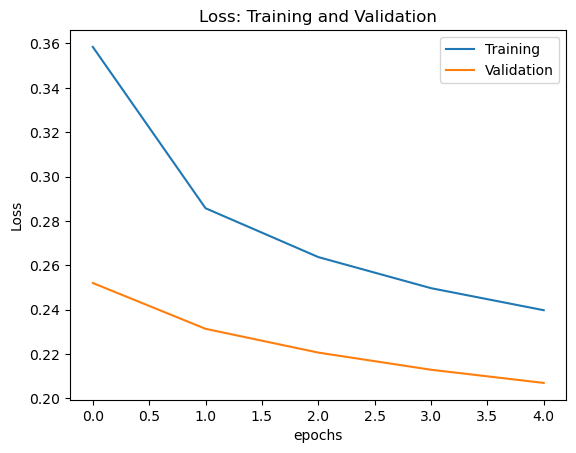

In [28]:
plt.plot(epoch_train_loss, label='Training')
plt.plot(epoch_test_loss, label='Validation')
plt.title('Loss: Training and Validation')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

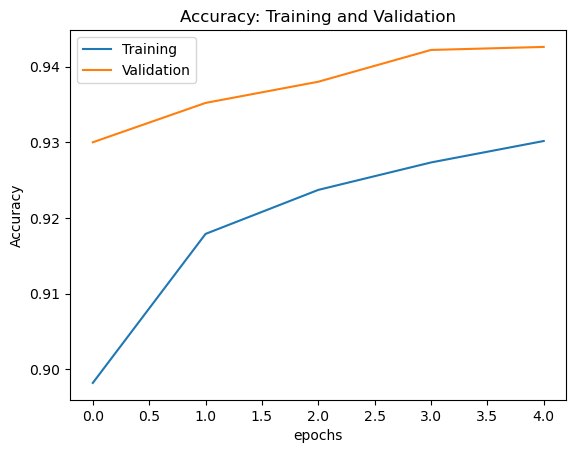

In [29]:
plt.plot(train_acc, label='Training')
plt.plot(test_acc, label='Validation')
plt.title('Accuracy: Training and Validation')
plt.xlabel('epochs')
plt.ylabel('Accuracy') 
plt.legend()
plt.show()

### 2. 
Train the neural network from a random initialization multiple times (at least 3) and plot an average and a standard deviation of the objective value2 in each iteration (e.g., see: here). What does this tell you?

In [80]:
records_list_2 = []
learning_rate = 0.003
(xtrain, ytrain), (xtest, ytest), output_num = load_mnist()
xtrain_norm = xtrain.astype(np.float32) / 255
xtest_norm = xtest.astype(np.float32) / 255
epoch_size = 5
batch_size = 64

In [81]:
records = SGD(learning_rate, epoch_size, batch_size, output_num, xtrain_norm, ytrain, xtest_norm, ytest)
records_list_2.append(records)

start SGD...
start epoch...


Epoch 1/5: 55040batch [01:33, 591.63batch/s]                                    


train_acc: 0.9018047480620154 , train_loss:  0.334997199920664
test_acc: 0.9418 , test_loss:  0.2122885694959352
start epoch...


Epoch 2/5: 55040batch [01:30, 607.60batch/s]                                    


train_acc: 0.9219173934108527 , train_loss:  0.2670891683782448
test_acc: 0.944 , test_loss:  0.1995484536745694
start epoch...


Epoch 3/5: 55040batch [01:31, 604.35batch/s]                                    


train_acc: 0.9261203972868218 , train_loss:  0.25163247851037696
test_acc: 0.9466 , test_loss:  0.19440274230898777
start epoch...


Epoch 4/5: 55040batch [01:32, 595.09batch/s]                                    


train_acc: 0.9283369670542636 , train_loss:  0.2427205650777093
test_acc: 0.9474 , test_loss:  0.19080815409928253
start epoch...


Epoch 5/5: 55040batch [01:35, 574.28batch/s]                                    


train_acc: 0.9303536821705427 , train_loss:  0.23638890838145146
test_acc: 0.9482 , test_loss:  0.1880123207250758


In [82]:
records = SGD(learning_rate, epoch_size, batch_size, output_num, xtrain_norm, ytrain, xtest_norm, ytest)
records_list_2.append(records)

start SGD...
start epoch...


Epoch 1/5: 55040batch [01:34, 581.97batch/s]                                    


train_acc: 0.9017865794573643 , train_loss:  0.33224940660834196
test_acc: 0.9392 , test_loss:  0.21741384185710955
start epoch...


Epoch 2/5: 55040batch [01:34, 583.54batch/s]                                    


train_acc: 0.9214450096899224 , train_loss:  0.26448744278727976
test_acc: 0.9412 , test_loss:  0.20662208462287482
start epoch...


Epoch 3/5: 55040batch [01:34, 582.26batch/s]                                    


train_acc: 0.9252785852713178 , train_loss:  0.25062165697751465
test_acc: 0.9406 , test_loss:  0.20288673194706033
start epoch...


Epoch 4/5: 55040batch [01:34, 584.34batch/s]                                    


train_acc: 0.9275859980620155 , train_loss:  0.24339960419353798
test_acc: 0.9418 , test_loss:  0.20142897861080636
start epoch...


Epoch 5/5: 55040batch [01:33, 585.72batch/s]                                    


train_acc: 0.9289304748062015 , train_loss:  0.2385619515796364
test_acc: 0.941 , test_loss:  0.20073553880651465


In [84]:
records = SGD(learning_rate, epoch_size, batch_size, output_num, xtrain_norm, ytrain, xtest_norm, ytest)
records_list_2.append(records)

start SGD...
start epoch...


Epoch 1/5: 55040batch [01:32, 595.63batch/s]                                    


train_acc: 0.9014958817829456 , train_loss:  0.33305746297816446
test_acc: 0.939 , test_loss:  0.22460259355783638
start epoch...


Epoch 2/5: 55040batch [01:31, 602.86batch/s]                                    


train_acc: 0.9209605135658916 , train_loss:  0.26545145958274025
test_acc: 0.9396 , test_loss:  0.21519162390805674
start epoch...


Epoch 3/5: 55040batch [01:32, 595.11batch/s]                                    


train_acc: 0.9263384205426357 , train_loss:  0.2490684860888439
test_acc: 0.9418 , test_loss:  0.2125260327676321
start epoch...


Epoch 4/5: 55040batch [01:32, 597.40batch/s]                                    


train_acc: 0.9296451065891473 , train_loss:  0.23952286903489037
test_acc: 0.9404 , test_loss:  0.21122105295041896
start epoch...


Epoch 5/5: 55040batch [01:33, 589.76batch/s]                                    


train_acc: 0.9317163275193799 , train_loss:  0.23292857023089944
test_acc: 0.9384 , test_loss:  0.20991479467624102


In [85]:
records = SGD(learning_rate, epoch_size, batch_size, output_num, xtrain_norm, ytrain, xtest_norm, ytest)
records_list_2.append(records)

start SGD...
start epoch...


Epoch 1/5: 55040batch [01:31, 600.69batch/s]                                    


train_acc: 0.9013687015503875 , train_loss:  0.3364003145022534
test_acc: 0.9422 , test_loss:  0.21162655617796025
start epoch...


Epoch 2/5: 55040batch [01:31, 600.65batch/s]                                    


train_acc: 0.9213723352713178 , train_loss:  0.26910032828470665
test_acc: 0.948 , test_loss:  0.19654453754780224
start epoch...


Epoch 3/5: 55040batch [01:33, 591.70batch/s]                                    


train_acc: 0.926532218992248 , train_loss:  0.2534255070161028
test_acc: 0.9478 , test_loss:  0.1905424750341098
start epoch...


Epoch 4/5: 55040batch [01:30, 607.25batch/s]                                    


train_acc: 0.9280583817829456 , train_loss:  0.2441488777011666
test_acc: 0.9478 , test_loss:  0.18872702117527962
start epoch...


Epoch 5/5: 55040batch [01:33, 590.04batch/s]                                    


train_acc: 0.930220445736434 , train_loss:  0.23772379646864467
test_acc: 0.9478 , test_loss:  0.18866779909778025


In [137]:
# epoch_train_loss = records["epoch_train_loss"]
# epoch_test_loss = records["epoch_test_loss"]
# train_acc = records["train_acc"]
# test_acc = records["test_acc"]
# batch_train_loss = records["batch_train_loss"]
# batch_test_loss = records["batch_test_loss"]
# batch_train_acc = records["batch_train_acc"]
# batch_test_acc = records["batch_test_acc"]


In [158]:
def get_plt_list_2(name):
    plt_list = np.vstack((records_list_2[0][name], records_list_2[1][name],
                        records_list_2[2][name],records_list_2[3][name]))

    return plt_list

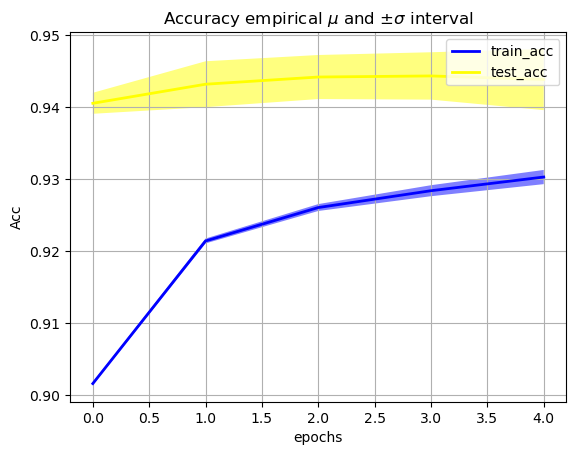

In [174]:
name1 = "train_acc"
name2 = "test_acc"

plt_line_1 = get_plt_list_2(name1)
plt_line_2 = get_plt_list_2(name2)

# Nsteps length arrays empirical means and standard deviations of both
# populations over time
mu1 = plt_line_1.mean(axis=0)
sigma1 = plt_line_1.std(axis=0)


mu2 = plt_line_2.mean(axis=0)
sigma2 = plt_line_2.std(axis=0)
mu1,sigma1,mu2,sigma2

# plot it!
t = np.arange(5)

fig, ax = plt.subplots(1)
ax.plot(t, mu1, lw=2, label=name1, color='blue')
ax.plot(t, mu2, lw=2, label=name2, color='yellow')
ax.fill_between(t, mu1+sigma1, mu1-sigma1, facecolor='blue', alpha=0.5)
ax.fill_between(t, mu2+sigma2, mu2-sigma2, facecolor='yellow', alpha=0.5)
ax.set_title(r'Accuracy empirical $\mu$ and $\pm \sigma$ interval')
ax.legend(loc='upper right')
ax.set_xlabel('epochs')
ax.set_ylabel('Acc')
ax.grid()

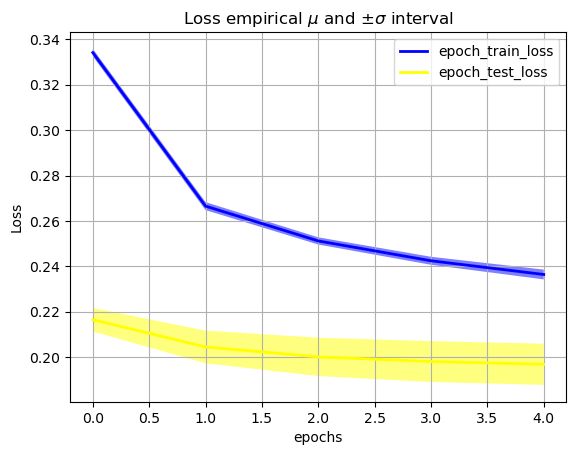

In [172]:
name1 = "epoch_train_loss"
name2 = "epoch_test_loss"

plt_line_1 = get_plt_list_2(name1)
plt_line_2 = get_plt_list_2(name2)

# Nsteps length arrays empirical means and standard deviations of both
# populations over time
mu1 = plt_line_1.mean(axis=0)
sigma1 = plt_line_1.std(axis=0)


mu2 = plt_line_2.mean(axis=0)
sigma2 = plt_line_2.std(axis=0)
mu1,sigma1,mu2,sigma2

# plot it!
t = np.arange(5)

fig, ax = plt.subplots(1)
ax.plot(t, mu1, lw=2, label=name1, color='blue')
ax.plot(t, mu2, lw=2, label=name2, color='yellow')
ax.fill_between(t, mu1+sigma1, mu1-sigma1, facecolor='blue', alpha=0.5)
ax.fill_between(t, mu2+sigma2, mu2-sigma2, facecolor='yellow', alpha=0.5)
ax.set_title(r'Loss empirical $\mu$ and $\pm \sigma$ interval')
ax.legend(loc='upper right')
ax.set_xlabel('epochs')
ax.set_ylabel('Loss')
ax.grid()

### 3. 
Run the SGD with different learning rates (e.g., 0.001, 0.003, 0.01, 0.03). Analyze how the learning rate value influences the final performance.

In [44]:
records_list = []

learning_rates01 = 0.001
records = SGD(learning_rates01, epoch_size, batch_size, output_num, xtrain_norm, ytrain, xtest_norm, ytest)

start SGD...
start epoch...


Epoch 1/5: 55040batch [01:32, 592.61batch/s]                                    


train_acc: 0.8974200581395348 , train_loss:  0.35738882250189213
test_acc: 0.9354 , test_loss:  0.23427858598369672
start epoch...


Epoch 2/5: 55040batch [01:32, 592.78batch/s]                                    


train_acc: 0.9175872093023256 , train_loss:  0.28325898528129934
test_acc: 0.9404 , test_loss:  0.21478057814198884
start epoch...


Epoch 3/5: 55040batch [01:35, 576.06batch/s]                                    


train_acc: 0.9236736918604651 , train_loss:  0.2622209447753985
test_acc: 0.9436 , test_loss:  0.20453695446542705
start epoch...


Epoch 4/5: 55040batch [01:33, 587.56batch/s]                                    


train_acc: 0.9276526162790698 , train_loss:  0.24928784870513812
test_acc: 0.9448 , test_loss:  0.19798222236601543
start epoch...


Epoch 5/5: 55040batch [01:33, 589.99batch/s]                                    


train_acc: 0.9306504360465117 , train_loss:  0.2403464858510713
test_acc: 0.945 , test_loss:  0.19343023038979287


In [45]:
records_list.append(records)

In [46]:
records = SGD(0.003, epoch_size, batch_size, output_num, xtrain_norm, ytrain, xtest_norm, ytest)
records_list.append(records)

start SGD...
start epoch...


Epoch 1/5: 55040batch [01:34, 579.63batch/s]                                    


train_acc: 0.9011143410852712 , train_loss:  0.33623901192134653
test_acc: 0.9344 , test_loss:  0.2209643299918548
start epoch...


Epoch 2/5: 55040batch [01:33, 590.50batch/s]                                    


train_acc: 0.9222625968992247 , train_loss:  0.26452399633758794
test_acc: 0.9416 , test_loss:  0.2023476004225128
start epoch...


Epoch 3/5: 55040batch [01:33, 590.41batch/s]                                    


train_acc: 0.9273316375968992 , train_loss:  0.24870411774426157
test_acc: 0.9432 , test_loss:  0.19622857286247727
start epoch...


Epoch 4/5: 55040batch [01:33, 588.45batch/s]                                    


train_acc: 0.9302386143410852 , train_loss:  0.24003417219802053
test_acc: 0.944 , test_loss:  0.19372847865809767
start epoch...


Epoch 5/5: 55040batch [01:32, 594.07batch/s]                                    


train_acc: 0.9317466085271316 , train_loss:  0.2343044983610765
test_acc: 0.946 , test_loss:  0.19286415900501944


In [47]:
records = SGD( 0.01, epoch_size, batch_size, output_num, xtrain_norm, ytrain, xtest_norm, ytest)
records_list.append(records)

start SGD...
start epoch...


Epoch 1/5: 55040batch [01:32, 593.65batch/s]                                    


train_acc: 0.8989401647286822 , train_loss:  0.34482600612469994
test_acc: 0.923 , test_loss:  0.24452902774472035
start epoch...


Epoch 2/5: 55040batch [01:33, 590.16batch/s]                                    


train_acc: 0.9122032461240311 , train_loss:  0.29199948828753663
test_acc: 0.9254 , test_loss:  0.2397250801093289
start epoch...


Epoch 3/5: 55040batch [01:31, 604.34batch/s]                                    


train_acc: 0.9153040213178294 , train_loss:  0.2800473718528208
test_acc: 0.9294 , test_loss:  0.23347519610005937
start epoch...


Epoch 4/5: 55040batch [01:33, 588.33batch/s]                                    


train_acc: 0.9185804263565892 , train_loss:  0.268859510888647
test_acc: 0.93 , test_loss:  0.2290535225950419
start epoch...


Epoch 5/5: 55040batch [01:32, 592.42batch/s]                                    


train_acc: 0.9204275678294572 , train_loss:  0.26197695258022713
test_acc: 0.934 , test_loss:  0.2222386757485944


In [48]:
records = SGD(0.03, epoch_size, batch_size, output_num, xtrain_norm, ytrain, xtest_norm, ytest)
records_list.append(records)

start SGD...
start epoch...


Epoch 1/5: 55040batch [01:32, 594.83batch/s]                                    


train_acc: 0.8868156492248062 , train_loss:  0.38356410478313424
test_acc: 0.924 , test_loss:  0.2508046634508891
start epoch...


Epoch 2/5: 55040batch [01:34, 585.26batch/s]                                    


train_acc: 0.9058200096899224 , train_loss:  0.3139437805946613
test_acc: 0.9252 , test_loss:  0.2510627343194968
start epoch...


Epoch 3/5: 55040batch [01:32, 593.89batch/s]                                    


train_acc: 0.9101623062015503 , train_loss:  0.29667838714911715
test_acc: 0.9262 , test_loss:  0.24158024253242782
start epoch...


Epoch 4/5: 55040batch [01:32, 594.16batch/s]                                    


train_acc: 0.909938226744186 , train_loss:  0.29509146593122854
test_acc: 0.928 , test_loss:  0.253270782125492
start epoch...


Epoch 5/5: 55040batch [01:34, 579.99batch/s]                                    


train_acc: 0.9135234980620154 , train_loss:  0.28659698779773785
test_acc: 0.9258 , test_loss:  0.2480639409576958


In [51]:
# epoch_train_loss = records["epoch_train_loss"]
# epoch_test_loss = records["epoch_test_loss"]
# train_acc = records["train_acc"]
# test_acc = records["test_acc"]
# batch_train_loss = records["batch_train_loss"]
# batch_test_loss = records["batch_test_loss"]
# batch_train_acc = records["batch_train_acc"]
# batch_test_acc = records["batch_test_acc"]

4

In [ ]:
train_acc
test_acc

In [60]:
def get_plt_data(name):
    plt_list = {}
    for i in range(len(records_list)):
        plt_list[i] = records_list[i][name]
    #     test_loss = records_list[i]["test_loss"]
    return plt_list

In [74]:
# 假设你有四个列表的数据
def draw_plt(name,title):
    x_values = [1, 2, 3, 4, 5]
    plt_list = get_plt_data(name)
    y1_values = plt_list[0].tolist()
    y2_values = plt_list[1].tolist()
    y3_values = plt_list[2].tolist()
    y4_values = plt_list[3].tolist()

    # 绘制四个列表的数据，指定颜色和数据点标记，并添加线段连接
    plt.plot(x_values, y1_values, label='0.001', color='blue', marker='o', linestyle='-')
    plt.plot(x_values, y2_values, label='0.003', color='green', marker='o', linestyle='-')
    plt.plot(x_values, y3_values, label='0.01', color='red', marker='o', linestyle='-')
    plt.plot(x_values, y4_values, label='0.03', color='purple', marker='o', linestyle='-')

    # 添加标题和标签
    plt.title(title)
    plt.xlabel('epoch')
    plt.ylabel(name)

    # 添加图例到右上角
    plt.legend(loc='upper right')

    # 显示图形
    plt.show()

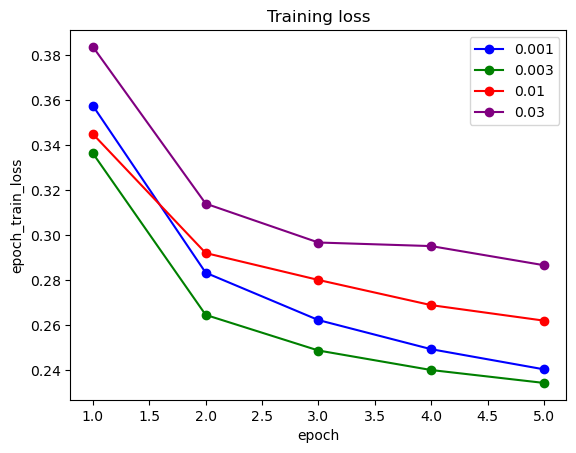

In [75]:
name = "epoch_train_loss"
title = 'Training loss'

draw_plt(name,title)

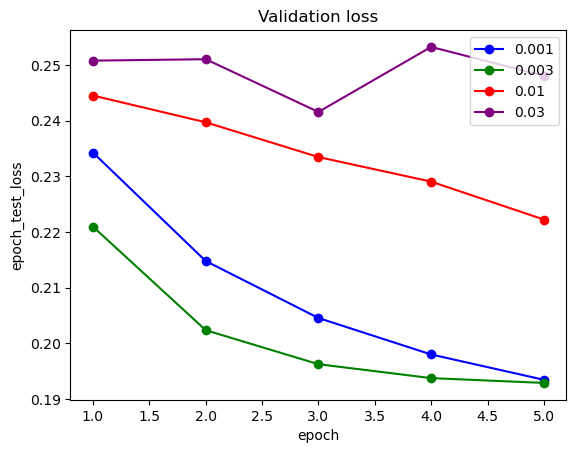

In [76]:
name = "epoch_test_loss"
title = 'Validation loss'

draw_plt(name,title)

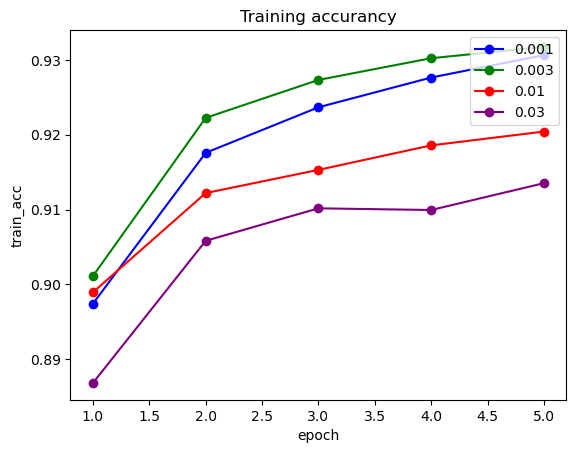

In [77]:
name = "train_acc"
title = 'Training accurancy'

draw_plt(name,title)

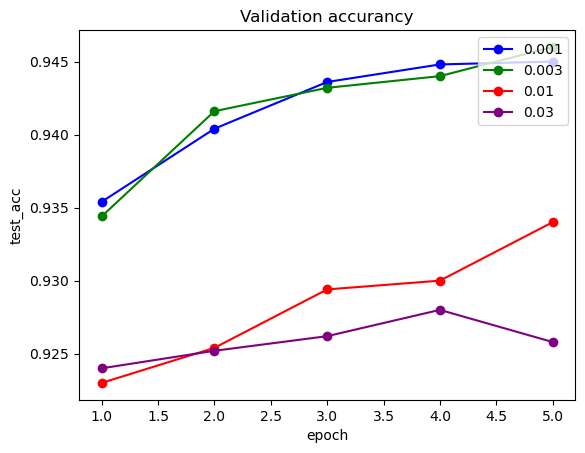

In [78]:
name = "test_acc"
title = 'Validation accurancy'

draw_plt(name,title)